# Red dirigida a partir de una matriz de descomposición de valor agregado por fuente (2022)

Banxico. (2025). Tercer reporte trimestral, recuardo 1

In [1]:
import csv
from typing import Dict, List, Tuple, Optional, Any

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from typing import List, Any, Dict

In [3]:
CSV_PATH = "data/banxico/matriz de descomposición de valor agregado por fuente (2022).csv"


def parse_valor_agregado_csv(path: str) -> Tuple[pd.DataFrame, List[str]]:
    with open(path, "r", encoding="latin1", newline="") as f:
        rows = list(csv.reader(f, delimiter=",", quotechar='"'))

    # Header con códigos de proveedores: ['', 'Región','País','BRA',...,'VNM']
    header = rows[4]
    provider_codes = header[3:]
    providers = provider_codes + ["RDM", "TOTAL"]

    data_rows: List[List[str]] = []
    row_labels: List[str] = []

    for r in rows[5:]:
        if len(r) == 0:
            continue
        if len(r) == 1:
            continue
        if isinstance(r[0], str) and r[0].startswith("Nota:"):
            break

        # Normalización por longitud:
        if len(r) == 26:
            row_country = r[2]
            vals = r[3:]
        elif len(r) == 25:
            row_country = r[1]
            vals = r[2:]
        elif len(r) == 24:
            row_country = r[0]
            vals = r[1:]
        else:
            row_country = r[0]
            vals = r[1:]

        # Queremos 23 valores = 21 países + RDM + TOTAL
        if len(vals) < 23:
            vals = vals + [""] * (23 - len(vals))
        if len(vals) > 23:
            vals = vals[:23]

        row_labels.append(row_country)
        data_rows.append(vals)

    M_full = pd.DataFrame(data_rows, index=row_labels, columns=providers)

    # Convertir a float (vacíos -> NaN -> 0)
    for c in M_full.columns:
        M_full[c] = pd.to_numeric(M_full[c].replace("", np.nan), errors="coerce")
    M_full = M_full.fillna(0.0)

    return M_full, providers


M_full, providers = parse_valor_agregado_csv(CSV_PATH)

print("Forma M_full:", M_full.shape)
display(M_full.head())

Forma M_full: (21, 23)


,BRA,CHL,COL,PER,MEX,CAN,EUA,ALE,FRA,ITA,...,PRT,CHN,JPN,KOR,TWN,IND,IDN,VNM,RDM,TOTAL
BRA,0.0,1.2,0.6,0.5,1.4,2.1,19.9,4.5,2.3,1.7,...,0.5,17.0,2.0,2.2,0.8,2.7,0.7,0.5,33.6,100
CHL,10.2,0.0,1.4,1.9,2.0,2.7,22.5,2.9,1.5,1.0,...,0.2,18.3,2.1,1.6,0.6,1.5,0.6,0.5,24.8,100
COL,5.2,1.3,0.0,2.1,3.3,2.4,26.4,3.5,1.8,1.4,...,0.2,19.1,1.6,1.3,0.8,2.1,0.6,0.6,21.7,100
PER,4.7,2.5,2.0,0.0,2.0,2.3,26.5,2.9,1.0,1.1,...,0.1,21.7,2.3,1.2,0.7,2.2,0.8,0.5,21.5,100
MEX,2.1,0.4,0.5,0.3,0.0,3.3,41.6,3.6,1.0,1.2,...,0.1,17.9,3.0,2.9,2.1,1.1,0.6,0.9,14.7,100


## Matriz de pesos

In [3]:
W = M_full.drop(columns=["TOTAL", "RDM"]).copy()

print("Forma W:", W.shape)
print("Nodos fila (b):", list(W.index))
print("Nodos columna (s):", list(W.columns))

Forma W: (21, 21)
Nodos fila (b): ['BRA', 'CHL', 'COL', 'PER', 'MEX', 'CAN', 'EUA', 'ALE', 'FRA', 'ITA', 'ESP', 'UK', 'POL', 'PRT', 'CHN', 'JPN', 'KOR', 'TWN', 'IND', 'IDN', 'VNM']
Nodos columna (s): ['BRA', 'CHL', 'COL', 'PER', 'MEX', 'CAN', 'EUA', 'ALE', 'FRA', 'ITA', 'ESP', 'UK', 'POL', 'PRT', 'CHN', 'JPN', 'KOR', 'TWN', 'IND', 'IDN', 'VNM']


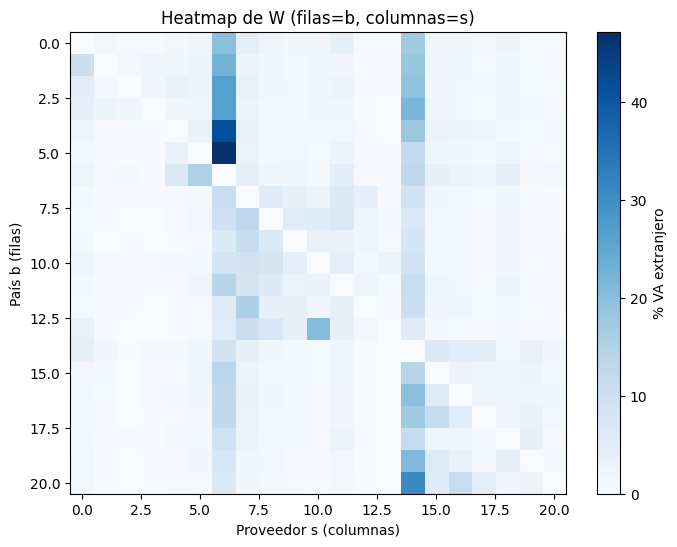

In [4]:
plt.figure(figsize=(8, 6))
plt.imshow(W.to_numpy(), aspect="auto", cmap="Blues")
plt.title("Heatmap de W (filas=b, columnas=s)")
plt.xlabel("Proveedor s (columnas)")
plt.ylabel("País b (filas)")
plt.colorbar(label="% VA extranjero")
plt.show()

# Construir el digrafo ponderado

In [5]:
def build_digraph_from_weight_matrix(W: pd.DataFrame, eps: float = 0.0) -> nx.DiGraph:
    G = nx.DiGraph()

    row_nodes = list(W.index)
    col_nodes = list(W.columns)
    G.add_nodes_from(sorted(set(row_nodes) | set(col_nodes)))

    for b in row_nodes:
        for s in col_nodes:
            w = float(W.loc[b, s])
            if w > eps:
                G.add_edge(s, b, weight=w)

    return G


G = build_digraph_from_weight_matrix(W, eps=0.0)

print("Nodos |V| =", G.number_of_nodes())
print("Aristas |E| =", G.number_of_edges())

weights = np.array([G[u][v]["weight"] for u, v in G.edges()], dtype=float)
print("Peso min / mediana / max:", float(weights.min()), float(np.median(weights)), float(weights.max()))

Nodos |V| = 21
Aristas |E| = 420
Peso min / mediana / max: 0.1 1.3 47.2


## Grados y fuerzas (ponderadas)

In [6]:
def degrees_and_strengths(G: nx.DiGraph) -> pd.DataFrame:
    nodes = list(G.nodes())

    sin = {v: 0.0 for v in nodes}
    sout = {v: 0.0 for v in nodes}
    for u, v, data in G.edges(data=True):
        w = float(data.get("weight", 1.0))
        sout[u] += w
        sin[v] += w

    df = pd.DataFrame({
        "in_strength": pd.Series(sin),
        "out_strength": pd.Series(sout),
    }).fillna(0)

    return df.sort_values(["out_strength", "in_strength"], ascending=False)


stats = degrees_and_strengths(G)
display(stats.head(12))

,in_strength,out_strength
EUA,68.9,315.1
CHN,50.0,294.2
ALE,52.3,111.4
JPN,49.8,63.9
UK,59.3,58.3
FRA,58.5,57.2
ESP,58.1,51.3
KOR,59.9,51.0
BRA,66.4,46.5
CAN,82.0,44.4


# Visualizaciones

In [ ]:
FIGSIZE = (9, 7)
CMAP = "rainbow"


def _edge_widths_from_weights(G: nx.DiGraph, min_w: float = 0.5, max_w: float = 4.0) -> List[float]:
    w = np.array([G[u][v]["weight"] for u, v in G.edges()], dtype=float)
    if w.size == 0:
        return []
    w_min, w_max = float(w.min()), float(w.max())
    if abs(w_max - w_min) < 1e-12:
        return [0.5 * (min_w + max_w)] * len(w)
    z = (w - w_min) / (w_max - w_min)
    return list(min_w + z * (max_w - min_w))


def _normalize01(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    if x.size == 0:
        return x
    xmin, xmax = float(x.min()), float(x.max())
    if abs(xmax - xmin) < 1e-12:
        return np.zeros_like(x)
    return (x - xmin) / (xmax - xmin)


def _sizes_from_metric(metric: np.ndarray, s_min: float, s_max: float, mode: str) -> List[float]:
    m = np.asarray(metric, dtype=float)
    m = np.maximum(m, 0.0)
    if mode == "sqrt":
        m = np.sqrt(m)
    elif mode == "log1p":
        m = np.log1p(m)
    z = _normalize01(m)
    return list(s_min + z * (s_max - s_min))


def _node_rgba_map(nodes: List[Any], values: List[float]) -> Dict[Any, tuple]:
    cmap = cm.get_cmap(CMAP)
    z = _normalize01(np.asarray(values, dtype=float))
    return {n: cmap(float(z[i])) for i, n in enumerate(nodes)}


def _edge_colors_from_nodes(G: nx.DiGraph, node_color_map: Dict[Any, tuple], mode: str) -> List[tuple]:
    if mode == "target":
        return [node_color_map[v] for (u, v) in G.edges()]
    return [node_color_map[u] for (u, v) in G.edges()]


def draw_style_1(G: nx.DiGraph) -> None:
    stats = degrees_and_strengths(G)
    pos = nx.spring_layout(G, seed=7)

    nodes = list(G.nodes())
    supplier_weight = [float(stats.loc[v, "out_strength"]) for v in nodes]

    node_sizes = _sizes_from_metric(np.array(supplier_weight), s_min=350, s_max=1900, mode="sqrt")
    node_colors_map = _node_rgba_map(nodes, supplier_weight)
    node_colors = [node_colors_map[v] for v in nodes]

    widths = _edge_widths_from_weights(G, min_w=0.4, max_w=4.0)
    edge_colors = _edge_colors_from_nodes(G, node_colors_map, mode="source")

    plt.figure(figsize=FIGSIZE)
    nx.draw_networkx_edges(G, pos, alpha=0.60, arrows=True, arrowsize=10, width=widths, edge_color=edge_colors)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, node_shape="o")
    nx.draw_networkx_labels(G, pos, font_size=9)

    plt.title("Estructura global de proveedores")
    plt.axis("off")
    plt.show()


def draw_style_2(G: nx.DiGraph) -> None:
    stats = degrees_and_strengths(G)
    pos = nx.kamada_kawai_layout(G)

    nodes = list(G.nodes())
    buyer_weight = [float(stats.loc[v, "in_strength"]) for v in nodes]

    node_sizes = _sizes_from_metric(np.array(buyer_weight), s_min=320, s_max=1700, mode="log1p")
    node_colors_map = _node_rgba_map(nodes, buyer_weight)
    node_colors = [node_colors_map[v] for v in nodes]

    widths = _edge_widths_from_weights(G, min_w=0.4, max_w=4.0)
    edge_colors = _edge_colors_from_nodes(G, node_colors_map, mode="target")

    plt.figure(figsize=FIGSIZE)
    nx.draw_networkx_edges(G, pos, alpha=0.60, arrows=True, arrowsize=10, width=widths, edge_color=edge_colors)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, node_shape="o")
    nx.draw_networkx_labels(G, pos, font_size=9)

    plt.title("Estructura global de compradores de EUA y CHN ")
    plt.axis("off")
    plt.show()


def draw_style_3(G: nx.DiGraph) -> None:
    stats = degrees_and_strengths(G)
    pos = nx.circular_layout(G)

    nodes = list(G.nodes())
    total_weight = [float(stats.loc[v, "in_strength"] + stats.loc[v, "out_strength"]) for v in nodes]

    node_sizes = _sizes_from_metric(np.array(total_weight), s_min=330, s_max=1800, mode="sqrt")
    node_colors_map = _node_rgba_map(nodes, total_weight)
    node_colors = [node_colors_map[v] for v in nodes]

    widths = _edge_widths_from_weights(G, min_w=0.3, max_w=3.5)
    edge_colors = _edge_colors_from_nodes(G, node_colors_map, mode="source")

    plt.figure(figsize=FIGSIZE)
    nx.draw_networkx_edges(G, pos, alpha=0.60, arrows=True, arrowsize=10, width=widths, edge_color=edge_colors)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, node_shape="o")
    nx.draw_networkx_labels(G, pos, font_size=9)

    plt.title("Centralidad total por peso")
    plt.axis("off")
    plt.show()

C:\Users\herie\AppData\Local\Temp\ipykernel_21340\252830302.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(CMAP)


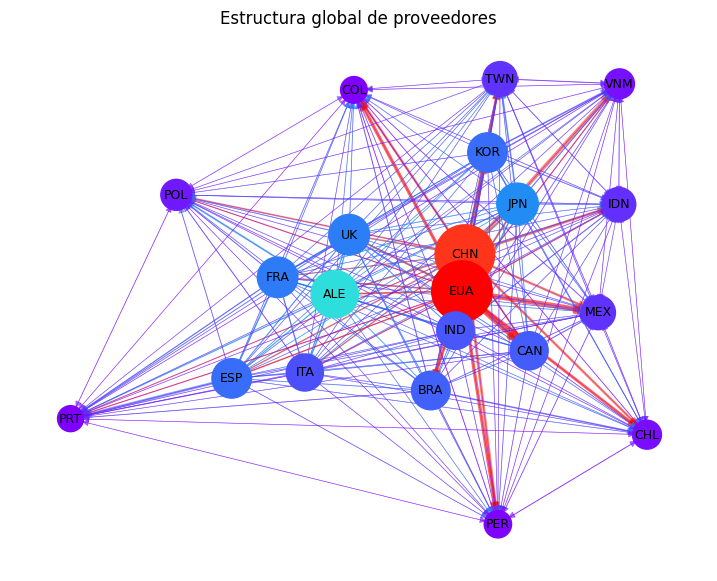

C:\Users\herie\AppData\Local\Temp\ipykernel_21340\252830302.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(CMAP)


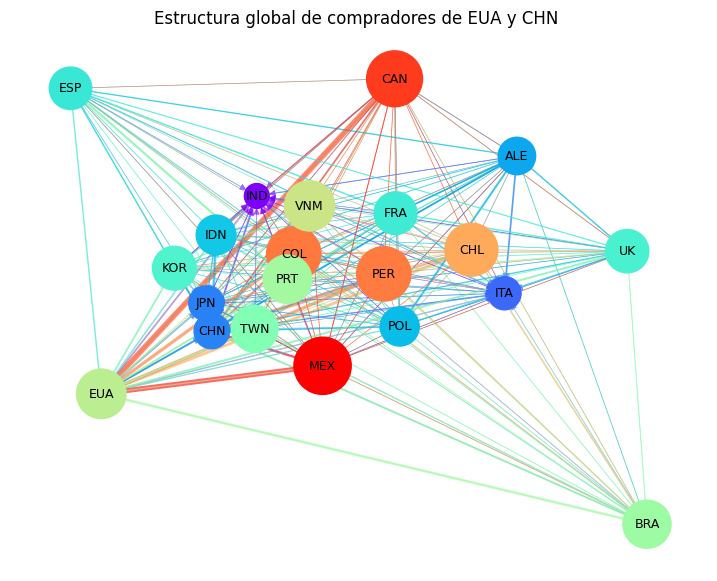

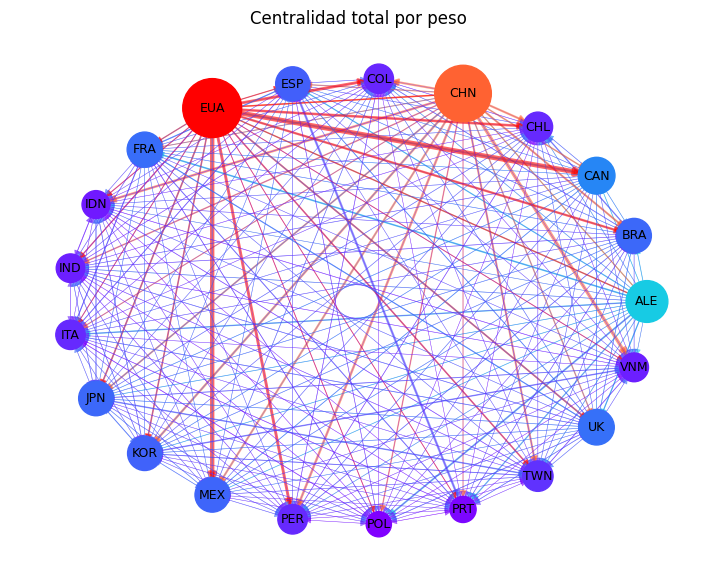

In [8]:
draw_style_1(G)
draw_style_2(G)
draw_style_3(G)

# Matrices de adyacencia

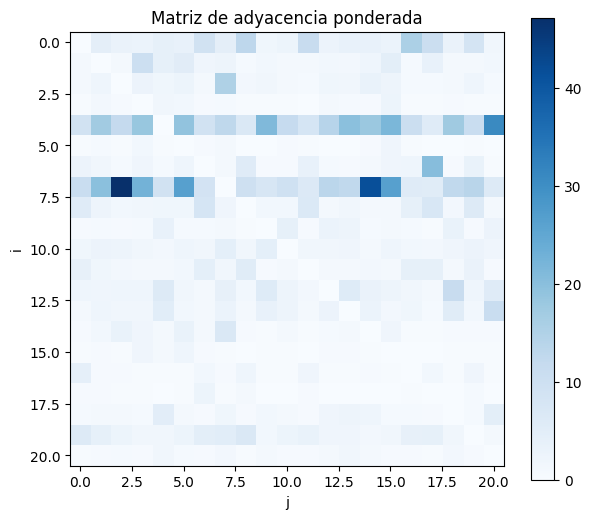

In [9]:
def adjacency_weighted(G: nx.DiGraph, nodelist: Optional[List[Any]] = None) -> np.ndarray:
    if nodelist is None:
        nodelist = list(G.nodes())
    idx = {v: i for i, v in enumerate(nodelist)}
    Wm = np.zeros((len(nodelist), len(nodelist)), dtype=float)
    for u, v, data in G.edges(data=True):
        Wm[idx[u], idx[v]] = float(data.get("weight", 1.0))
    return Wm


def show_matrix(M: np.ndarray, title: str, cmap: str = "Blues") -> None:
    plt.figure(figsize=(7, 6))
    plt.imshow(M, aspect="equal", cmap=cmap)
    plt.title(title)
    plt.xlabel("j")
    plt.ylabel("i")
    plt.colorbar()
    plt.show()


nodelist = sorted(G.nodes())
Wg = adjacency_weighted(G, nodelist=nodelist)


show_matrix(Wg, "Matriz de adyacencia ponderada")

# Subred 

In [10]:
def top_k_by_out_strength(G: nx.DiGraph, k: int = 8) -> List[Any]:
    stats = degrees_and_strengths(G)
    return list(stats.sort_values("out_strength", ascending=False).head(k).index)


nodes8 = top_k_by_out_strength(G, k=8)
nodes8

['EUA', 'CHN', 'ALE', 'JPN', 'UK', 'FRA', 'ESP', 'KOR']

C:\Users\herie\AppData\Local\Temp\ipykernel_21340\252830302.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(CMAP)


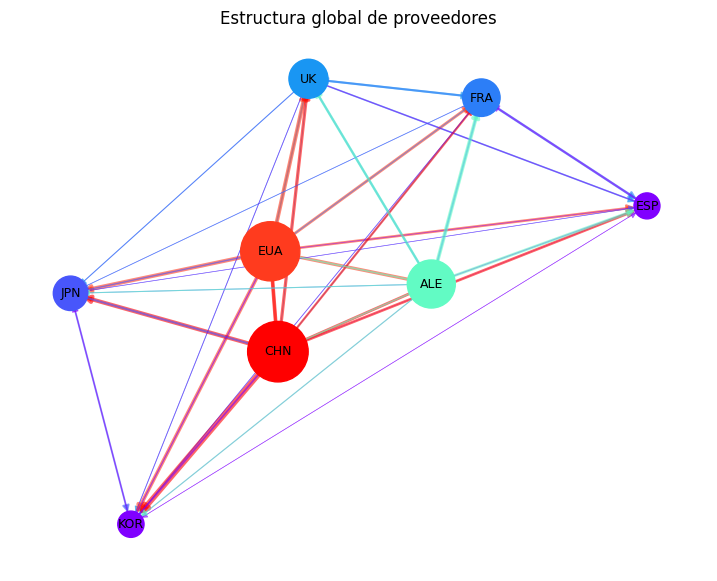

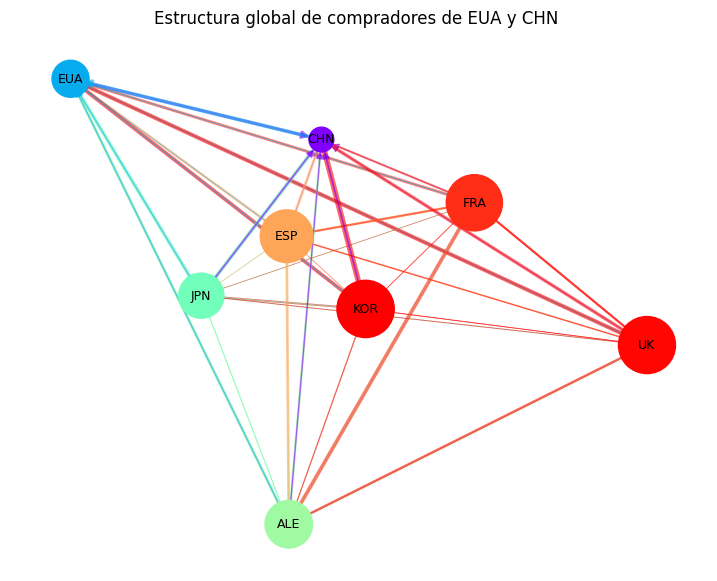

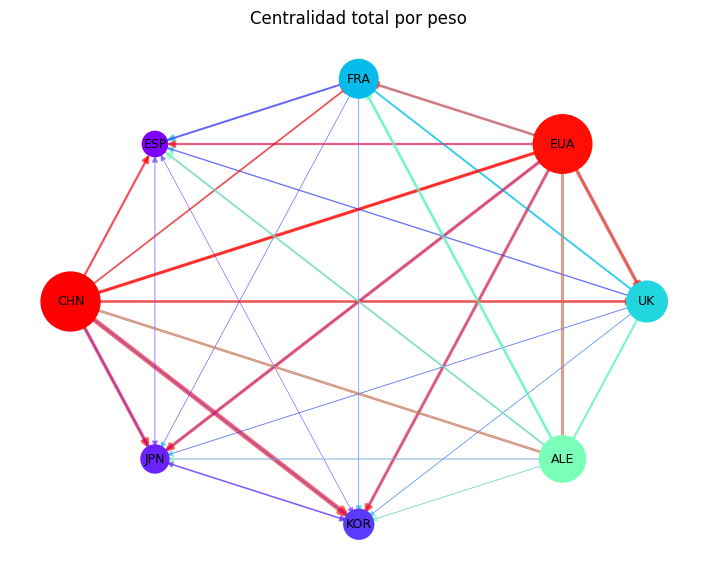

In [11]:
H = G.subgraph(nodes8).copy()
draw_style_1(H)
draw_style_2(H)
draw_style_3(H)


In [12]:
W_H = adjacency_weighted(H, nodelist=nodes8)

for k in range(1, 6):
    Wk = np.linalg.matrix_power(W_H, k)
    Wk_df = pd.DataFrame(Wk, index=nodes8, columns=nodes8)
    print(f"\nW_H^{k}:")
    display(Wk_df.round(3))


W_H^1:


,EUA,CHN,ALE,JPN,UK,FRA,ESP,KOR
EUA,0.0,9.1,10.9,13.3,13.7,9.7,8.5,12.5
CHN,12.9,0.0,9.1,14.0,10.9,7.0,9.1,19.9
ALE,4.5,3.9,0.0,2.6,8.2,13.0,9.2,3.4
JPN,3.7,5.9,2.2,0.0,2.1,1.3,1.1,5.8
UK,5.0,1.6,6.1,1.9,0.0,6.9,4.7,1.9
FRA,2.0,1.7,5.6,1.1,5.9,0.0,8.1,1.5
ESP,1.1,0.6,2.7,0.6,3.2,5.7,0.0,0.5
KOR,2.8,5.0,1.1,2.7,1.3,0.9,0.8,0.0



W_H^2:


,EUA,CHN,ALE,JPN,UK,FRA,ESP,KOR
EUA,347.90,226.99,286.66,231.29,317.18,376.92,350.68,340.12
CHN,226.98,369.78,323.56,282.83,377.04,406.62,332.62,309.15
ALE,146.57,114.03,241.66,159.03,220.18,186.41,223.16,188.62
JPN,116.56,77.48,123.46,159.27,151.77,131.77,130.42,177.63
UK,79.41,104.55,126.66,120.30,198.17,169.97,172.68,138.80
FRA,93.81,68.33,99.20,85.08,122.03,193.76,114.13,99.51
ESP,50.91,41.39,70.76,43.75,79.29,73.28,101.92,52.98
KOR,88.62,49.79,97.09,114.04,115.42,93.50,95.79,158.12



W_H^3:


,EUA,CHN,ALE,JPN,UK,FRA,ESP,KOR
EUA,8751.738,8707.735,11733.075,10696.232,13864.902,13484.343,12730.344,12525.339
CHN,11202.595,8035.939,12276.461,11234.945,14252.700,14139.870,13895.223,14429.006
ALE,5394.200,4960.719,6182.160,5440.680,7625.648,8529.270,7377.386,6654.877
JPN,3807.577,3915.126,4537.202,3947.127,5213.949,5435.497,4929.617,4893.610
UK,4273.153,3330.004,4861.219,3891.027,5254.593,5781.666,5343.188,4919.372
FRA,3044.494,2833.191,4078.559,3244.361,4659.865,4370.578,4648.021,3942.698
ESP,1817.692,1574.862,2255.317,1875.996,2648.095,2936.039,2517.116,2265.901
KOR,2813.349,3049.625,3330.162,2934.686,3856.161,4103.275,3651.351,3497.552



W_H^4:


,EUA,CHN,ALE,JPN,UK,FRA,ESP,KOR
EUA,350072.201,303879.705,406404.068,351445.113,470064.089,491784.670,457748.796,437546.252
CHN,355706.186,343432.251,439465.960,383345.895,511975.306,529648.672,486714.825,462087.818
ALE,193879.071,169699.268,237428.491,203532.070,272673.185,275147.198,264105.397,249692.425
JPN,141592.330,120640.571,166750.724,149305.330,194538.601,196933.584,186524.123,184350.100
UK,136717.382,126840.459,169708.927,148923.937,200477.607,204154.092,191091.761,180105.413
FRA,115098.674,100141.075,135891.655,117856.174,158634.276,168798.082,153208.983,144854.691
ESP,65631.735,58473.103,80155.180,67976.422,92824.640,95072.290,90634.821,83303.755
KOR,106481.216,88727.751,125080.278,112245.222,145694.426,146312.067,139689.225,139505.423



W_H^5:


,EUA,CHN,ALE,JPN,UK,FRA,ESP,KOR
EUA,1.211176e+07,1.089468e+07,1.469288e+07,1.285704e+07,1.711396e+07,1.750939e+07,1.640922e+07,1.570294e+07
CHN,1.327466e+07,1.153462e+07,1.575730e+07,1.377659e+07,1.830836e+07,1.878857e+07,1.767961e+07,1.700880e+07
ALE,6.913932e+06,6.202063e+06,8.297193e+06,7.225069e+06,9.673302e+06,1.003125e+07,9.310473e+06,8.851099e+06
JPN,4.946988e+06,4.499433e+06,5.965571e+06,5.201608e+06,6.934135e+06,7.151205e+06,6.656680e+06,6.361861e+06
UK,5.076143e+06,4.467652e+06,6.052340e+06,5.241767e+06,7.010082e+06,7.248472e+06,6.781462e+06,6.456546e+06
FRA,4.044291e+06,3.629697e+06,4.911086e+06,4.256222e+06,5.704688e+06,5.835486e+06,5.498197e+06,5.208345e+06
ESP,2.353731e+06,2.091957e+06,2.832023e+06,2.460176e+06,3.295787e+06,3.408408e+06,3.175181e+06,3.015095e+06
KOR,3.688126e+06,3.382221e+06,4.453708e+06,3.881838e+06,5.178902e+06,5.352999e+06,4.968217e+06,4.739125e+06


# Realiza una lista de grados: Identifica los nodos con mayor y con menor grado


In [13]:
deg_list = sorted(G.degree(weight="weight"), key=lambda x: x[1])

# menor y mayor grado (puede haber varios empatados)
min_deg = deg_list[0][1]
max_deg = deg_list[-1][1]

min_nodes = [(u, d) for u, d in deg_list if d == min_deg]
max_nodes = [(u, d) for u, d in deg_list if d == max_deg]

print(f"Grado minimo = {min_deg} | nodos: {len(min_nodes)}")
for u, d in min_nodes[:20]:
    print(G.nodes[u].get("label", str(u)), d)

print(f"\nGrado maximo = {max_deg} | nodos: {len(max_nodes)}")
for u, d in max_nodes[:20]:
    print(G.nodes[u].get("label", str(u)), d)

Grado minimo = 71.2 | nodos: 1
POL 71.2

Grado maximo = 384.0 | nodos: 1
EUA 384.0


In [14]:
k = 10
print("Ultimas 10:")
for u, d in deg_list[:k]:
    print(G.nodes[u].get("label", str(u)), d)

print("\nTop 10:")
for u, d in deg_list[-k:][::-1]:
    print(G.nodes[u].get("label", str(u)), d)

Ultimas 10:
POL 71.2
PRT 74.5
IDN 81.1
IND 83.7
VNM 84.60000000000001
COL 87.0
ITA 87.3
CHL 87.8
PER 87.8
TWN 91.8

Top 10:
EUA 384.0
CHN 344.2
ALE 163.7
CAN 126.4
UK 117.6
FRA 115.7
JPN 113.69999999999999
BRA 112.9
MEX 112.3
KOR 110.9


# Encuentra el grado promedio


In [15]:
deg = dict(G.degree(weight="weight"))
avg_degree = float(np.mean(list(deg.values())))
print('Grado promedio ', avg_degree)

Grado promedio  126.07619047619048


# Encuentra la densidad: ¿consideras que la red es dispersa o densa?


In [16]:
nx.density(G)

1.0

Es completamente conexa

# Calcula la conectividad por aristas y por nodos entre algunos pares de nodos (por ejemplo entre los de mayor y menor grado)

In [17]:
def pares_mayor_menor_grado(G: nx.Graph):
    deg = dict(G.degree(weight="weight"))
    u_max = max(deg, key=deg.get)
    u_min = min(deg, key=deg.get)
    return G, u_max, u_min, deg[u_max], deg[u_min]


def conectividades_entre_pares(G: nx.Graph, pares: list[tuple] | None = None):
    out = []
    for s, t in pares:
        k_node = nx.node_connectivity(G, s, t)
        k_edge = nx.edge_connectivity(G, s, t)
        out.append((s, t, k_node, k_edge))
    return out

H, u_max, u_min, dmax, dmin = pares_mayor_menor_grado(G)

res = conectividades_entre_pares(H, pares=[(u_max, u_min)])
(s, t, k_node, k_edge) = res[0]

print("Nodo mayor grado:", u_max, "| grado =", dmax)
print("Nodo menor grado:", u_min, "| grado =", dmin)
print(f"\nConectividad por nodos ({s},{t}) =", k_node)
print(f"Conectividad por aristas ({s},{t}) =", k_edge)


Nodo mayor grado: EUA | grado = 384.0
Nodo menor grado: POL | grado = 71.2

Conectividad por nodos (EUA,POL) = 20
Conectividad por aristas (EUA,POL) = 20


# Calcula su matriz Laplaciana (omite direcciones si es necesario), sus eigenvalores y sus eigenvectores (el espectro). Verifica que la multiplicidad del eigenvalor cero es la misma que la cantidad de componentes


In [18]:
L1 = nx.laplacian_matrix(G)
pd.DataFrame(L1.toarray())

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,111.4,-4.5,-3.1,-2.9,-3.9,-3.5,-9.2,-4.5,-13.0,-1.8,...,-11.2,-2.6,-3.4,-3.6,-2.9,-15.5,-10.4,-3.1,-8.2,-1.6
1,-1.0,46.5,-1.0,-10.2,-4.0,-5.2,-1.9,-2.3,-0.7,-1.4,...,-0.9,-1.4,-1.2,-2.1,-4.7,-0.7,-3.4,-1.1,-0.8,-1.4
2,-1.0,-2.1,44.4,-2.7,-1.8,-2.4,-0.9,-15.3,-1.2,-1.6,...,-0.6,-1.7,-1.5,-3.3,-2.3,-0.6,-0.7,-1.1,-2.1,-0.6
3,-0.2,-1.2,-0.5,12.5,-1.6,-1.3,-0.4,-0.7,-0.2,-0.3,...,-0.1,-0.9,-0.6,-0.4,-2.5,-0.2,-0.2,-0.5,-0.2,-0.3
4,-9.1,-17.0,-11.9,-18.3,294.2,-19.1,-9.1,-12.9,-7.0,-21.2,...,-8.1,-14.0,-19.9,-17.9,-21.7,-10.4,-5.6,-17.5,-10.9,-30.9
5,-0.2,-0.6,-0.3,-1.4,-0.3,8.5,-0.5,-0.8,-0.1,-0.1,...,-0.2,-0.1,-0.1,-0.5,-2.0,-0.3,-0.1,-0.1,-0.2,-0.1
6,-2.7,-1.5,-0.7,-1.9,-0.6,-2.1,51.3,-1.1,-5.7,-0.4,...,-3.4,-0.6,-0.5,-1.1,-2.0,-2.1,-20.4,-0.5,-3.2,-0.3
7,-10.9,-19.9,-47.2,-22.5,-9.1,-26.4,-8.5,315.1,-9.7,-7.7,...,-6.4,-13.3,-12.5,-41.6,-26.5,-5.7,-5.5,-12.5,-13.7,-6.0
8,-5.6,-2.3,-1.3,-1.5,-1.7,-1.8,-8.1,-2.0,57.2,-1.3,...,-6.5,-1.1,-1.5,-1.0,-1.0,-4.0,-7.2,-1.2,-5.9,-0.9
9,-0.4,-0.7,-0.5,-0.6,-3.6,-0.6,-0.7,-0.9,-0.3,26.3,...,-0.5,-2.8,-2.3,-0.6,-0.8,-0.6,-0.3,-3.2,-0.4,-2.6


In [19]:
eigenvals, eigenvectores = np.linalg.eig(L1.toarray())
eigenvals = np.sort(np.array([0.0 if x < 0 else float(x) for x in eigenvals]))
eigenvals

array([1.42108547e-14, 6.14652927e+00, 1.04234508e+01, 1.12418322e+01,
       1.37257969e+01, 1.54280030e+01, 2.15597171e+01, 2.62788741e+01,
       2.91072213e+01, 3.40047328e+01, 4.14533637e+01, 4.41666099e+01,
       4.72738426e+01, 5.01993324e+01, 5.21720337e+01, 5.89917227e+01,
       6.45548951e+01, 6.59170449e+01, 1.14478027e+02, 2.93946432e+02,
       3.22730538e+02])

Hay un eigenvector = 0. Hay una componente

In [20]:
eigenvectores

array([[ 1.06161400e-02, -2.29376305e-02, -9.89326765e-01,
        -2.18217890e-01,  1.60964198e-02,  3.52982027e-02,
        -6.71053085e-02,  1.17721473e-01, -6.21197212e-02,
        -6.15664265e-02, -8.67036496e-03, -1.76002508e-01,
        -4.57779645e-02,  1.16737401e-02, -9.88992485e-03,
         1.66006750e-01,  1.65893047e-03, -9.00722308e-02,
         3.34123008e-02, -2.84820471e-03, -1.21021778e-02],
       [ 1.89186232e-03, -1.67972216e-02,  1.16064574e-02,
        -2.18217890e-01, -4.16810296e-02,  2.84760866e-02,
        -2.35195979e-02, -7.58758180e-02, -8.54948623e-02,
         6.57107769e-03, -1.61602788e-01,  3.38599918e-03,
        -6.72452132e-02,  7.08663173e-03,  2.08065886e-02,
         6.96969385e-02, -1.17289694e-01,  2.53444802e-01,
         7.05079687e-01, -4.10716222e-02,  7.34225374e-02],
       [ 4.81964852e-02, -2.11968665e-02,  1.44630549e-02,
        -2.18217890e-01, -4.66328076e-02,  5.33862699e-02,
         1.17656602e-01, -7.45777431e-02, -8.66561335e